### Simulated reference tracking with a 1R robot
This jupyter notebook simulates tracking control for a 1R robot using adaptive Koopman model predictive control (KMPC), static KMPC, and linearization MPC and compares them. The dynamic parameters of the simulated system correspond to those of the real system which was used for the experiments shown in the paper. The used reference trajectorie corrpesponds to the one used for the real system experiments.   

First, the reference trajectory is loaded and a dynamic model for simulations is built:

In [55]:
# load all dependencies  
include("adaptiveKMPC.jl")   

# load reference trajectory of the single pendulum 
jldopen("./references/simple_pendulum.jld2", "r") do file
    global X_ref = file["xhist"]       
    global U_ref = file["uhist"]
    global T_ref = file["thist"]
end;  

# build single pendulum
m1 = [0.27]                 # link 1 mass 
l1 = [0.4]                  # link 1 lenght 
lc = [0.131]                # distance rotational axis to center of mass (COM) of link 1
I1 = [0.007479]             # moment of inertia of link 1 expressed in COM frame 
sp = nPendulum(m1,l1,lc,I1);
m = 1;                      # number of DOF


building simple pendulum


To clearly show the control processes, each controller is simulated separately. 

First **adaptive KMPC** is simulated. A set of parameters used for the predictive controller is defined and we need to specify a dictionary of lifting functions that are used for obtaining a data-driven linear model via extended dynamic mode decomposition (EDMD):      

In [56]:
# Basis functions (as used in the paper, note we include the original state as the first two entries)
θ1_func(x) = x[1]                           
ω1_func(x) = x[2]
s1_func(x) = sin(x[1])
c1_func(x) = cos(x[1])
ω1s1_func(x) =  x[2]*sin(x[1])
ω1c1_func(x) =  x[2]*cos(x[1])
dict = Dictionary([θ1_func, ω1_func, s1_func, c1_func, ω1s1_func, ω1c1_func]) 

# EDMD parameters 
Nb = 1000                                                     # length of circular buffer, containing data used for EDMD  
edmd_param = EDMDParameters(m, Nb, dict);                     # circular buffer is created within this struct   

# Controller parameters 
Q = [1;zeros(5)]                        # weights on tracking error (with these weight we only put emphasis on tracking of the joint angle θ1)                                    
Qf = [1;zeros(5)]                       # weights on tracking error, final state 
R = ones(m)*1                           # weights on control effort           
H = 30                                  # prediction horizon 
u_l = [-6.0]                            # lower limit on controls 
u_u = [6.0]                             # upper limit on controls 
constr = Constraints(u_l, u_u, H);      
akmpc_ctrl = AdaptiveKMPC(edmd_param, Q, Qf, R, X_ref, H, constr);    # build controller 

The simulated control experiment starts by exposing the system to a sequence of N feed forward controls. For the purpose of this tutorial, we use a sinusoidal torque sequence, such that the system oscillates around its stable equilibrium point. The system response is measured and data are used to fill the circular buffer, providing an initial internal model, such that actual tracking can be carried out. Note that control frequency and discretization of the reference trajectory have to match, such that the internal model produces useful predictions.         

In [57]:
# Preceding experiment for gathering data 
h = T_ref[2]-T_ref[1]               # discretization step length of the reference trajectory determines control freq. 
X_p = zeros(sp.n, Nb)                                  
U_p = zeros(m, Nb-1)     
T_p = 0:h:h*(Nb-1)

x0 = [0,0]                          # initial state 

X_p[:,1] = x0
for i in 1:Nb-1
    U_p[:,i] .= 0.15*cos(2π*0.05*i*h)           
    X_p[:,i+1] .= simulate(X_p[:,i], U_p[:,i], h, sp)
end      

# fill circular buffer 
update_buffer!(X_p, U_p, T_p, akmpc_ctrl)

# Reference tracking 
N = 1000                                                                    # duration of the tracking process is given by h*(N-1) (when the reference trajectory ends, the controller will track the last state)
X_a = zeros(sp.n, N)
U_a = zeros(m, N-1)    
T_a = 0:h:h*(N-1) 

X_a[:,1] = X_p[:,end]                                                       # assumption: the tracking process starts immediately after preceding experiment 
for i in 1:N-1         
    U_a[:,i] = get_control(X_a[:,i], i , akmpc_ctrl)                        # this function carries out the EDMD, building and solving of the MPC problem. Variable names are chosen according to the notation in the paper. 
    X_a[:,i+1] .= simulate(X_a[:,i], U_a[:,i], h, sp)                       # apply control 
    update_buffer!(X_a[:,i+1], U_a[:,i], T_a[i], akmpc_ctrl)                # buffer is updated in every time step to provide new data for the EDMD 
end  

Next, **linearization MPC** is carried out. Since the controller relies on model linearization, the dynamic model of the 1R robot has to be passed to the controller struct. For comparison the controller obtains the same constraints and weights (on tracking of the joint angle ) as adaptive KMPC. However, the dimension of the state space of nonlinear model is lower than the dimension of the lifted state space. Hence, the dimension of the tracking weight matrix (i.e. the zero entries) needs to be decreased.         

In [58]:
# Controller parameters 
Q_l = [1;zeros(1)]*1                        # weights on tracking error (with these weight we only put emphasis on tracking of the joint angle θ1)                                    
Qf_l = [1;zeros(1)]*1                       # weights on tracking error, final state 

lmpc_ctrl = linearizationMPC(sp, Q_l, Qf_l, R, X_ref, H, constr, h);                 # build linearization controller


# Reference tracking 
x0 = [0,0]                                                                  # initial state 
N = 1000                                                                    # duration of the tracking process is given by h*(N-1) (when the reference trajectory ends, the controller will track the last state)
X_l = zeros(sp.n, N)
U_l = zeros(m, N-1)    
T_l = 0:h:h*(N-1) 

X_l[:,1] = x0                                                               # assumption: the tracking process starts immediately after preceding experiment 
for i in 1:N-1         
    U_l[:,i] = get_control(X_l[:,i], i , lmpc_ctrl)                         # obtain internal model by linearization and solve of the MPC problem 
    X_l[:,i+1] .= simulate(X_l[:,i], U_l[:,i], h, sp)                       # apply control 
end  

Finally, **static KMPC** is deployed. As in the paper, the data for initial model build come from preceding closed-loop control with linearization MPC. Here we can use the data from previously 
carried out simulation, where the linearization MPC stabilizes the system along the same reference trajectory. This corresponds to the real system experiments described in the paper. 

Since this code is only for demonstrational purposes and code performance does not matter, we will misuse the *adaptiveKMPC* controller structure, and simply disable buffer updates. This means EDMD is still carried out, but on constant buffer data, such that the model is static. 


In [59]:
# EDMD parameters 
Nb = 1000                                                               # length of circular buffer, containing data used for EDMD  
edmd_param_a = EDMDParameters(m, Nb, dict);                             # circular buffer is created within this struct   

skmpc_ctrl = AdaptiveKMPC(edmd_param_a, Q, Qf, R, X_ref, H, constr);    # build controller (not really adaptive, since we will not update the internal buffer)

update_buffer!(X_l, U_l, T_l, skmpc_ctrl)                               # 

# Reference tracking 
N = 1000                                                                    # duration of the tracking process is given by h*(N-1) (when the reference trajectory ends, the controller will track the last state)
X_s = zeros(sp.n, N)
U_s = zeros(m, N-1)    
T_s = 0:h:h*(N-1) 
x0 = [0,0]

X_s[:,1] = x0                                                               # actual tracking process starts from the stable equilibrium position 
for i in 1:N-1         
    U_s[:,i] = get_control(X_s[:,i], i , skmpc_ctrl)                        # this function carries out the EDMD, building and solving of the MPC problem. Variable names are chosen according to the notation in the paper. 
    X_s[:,i+1] .= simulate(X_s[:,i], U_s[:,i], h, sp)                       # apply control 
    update_buffer!(X_s[:,i+1], U_s[:,i], T_s[i], skmpc_ctrl)                # buffer is updated in every time step to provide new data for the EDMD 
end  

The following show the control simulation results for each experiment. For adaptive KMPC, the open loop response during the preceding experiment is depicted. For static KMPC it is omitted, since the data come from closed-loop control with linearization MPC, which is depicted as separate experiment.



In [ ]:
# (pay attention to execute this cell only once!)
# append data from predecing experiment and actual tracking process for adaptive KMPC 
X_a = [X_p X_a[:,2:end]]
U_a = [U_p U_a]
T_a = [T_p;T_a[2:end].+T_p[end]] 

# for linearization MPC and static KMPC and reference add time of preceding experiment of adaptive KMPC, such that tracking results are chronologically    
T_l = T_l.+T_p[end] 
T_s = T_s.+T_p[end] 
T_ref = T_ref.+T_p[end]

# extend reference, since controllers tracked final state (X_ref[end]) after T_ref passed in the simulated experiments  
X_ref = [X_ref X_ref[:,end]]
T_ref = [T_ref; T_s[end]];

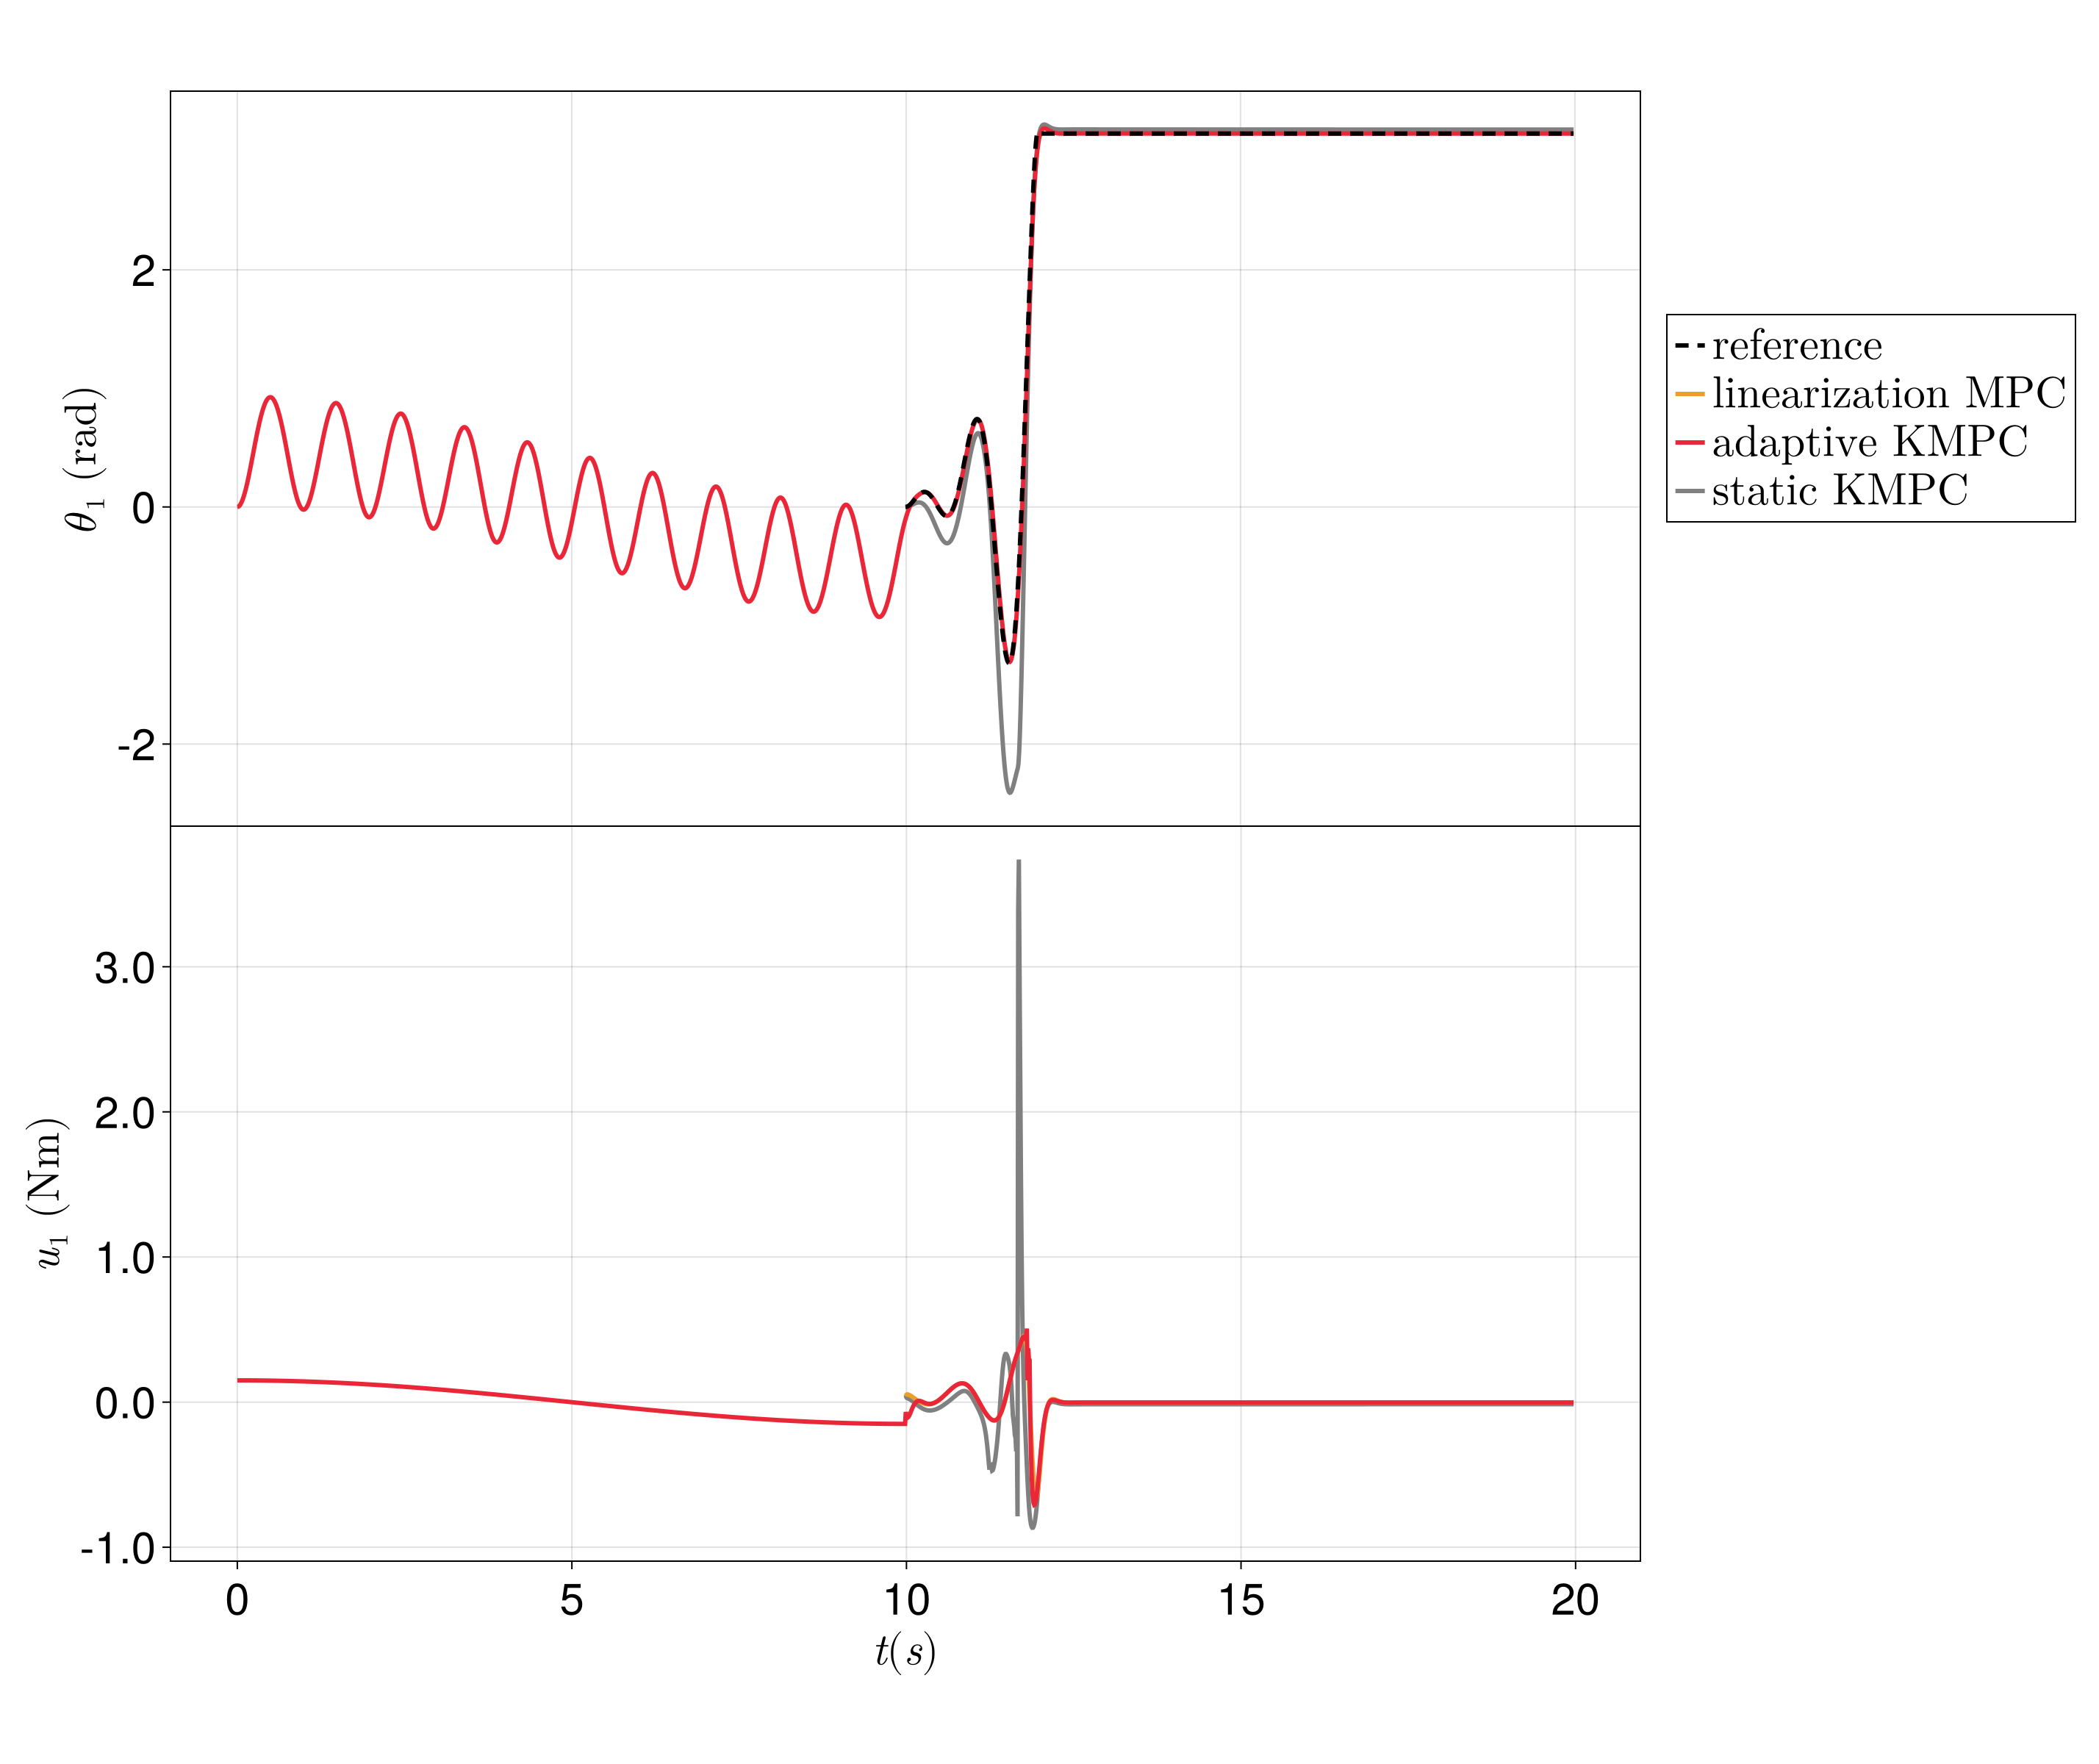

In [ ]:
fig = plot_tracking_results((X_a, U_a, T_a), (X_s, U_s, T_s),  (X_l, U_l, T_l), (X_ref, T_ref))

Note, in the simulations both, adaptive KMPC and linearization MPC, track the reference very accurate, resulting in overlap in the plots.  